In [7]:
import pandas as pd
import pandas_datareader as pdr
import FinanceDataReader as fdr
 
stock_type = {
    'kospi': 'stockMkt',
    'kosdaq': 'kosdaqMkt'
}
 
class StockCodes: 
    def __init__(self, mt=None):
        self.get_method = mt
        if self.get_method is None:
            self.stock_codes()
        else:
            self.codes2 = fdr.StockListing('KRX')[['Market','Name','Symbol']]
            self.codes2 = self.codes2.rename(columns={'Market':'market','Name': 'name', 'Symbol': 'code'})

    def krx_stock_codes(self, market_type='kospi'):
        download_link = 'http://kind.krx.co.kr/corpgeneral/corpList.do'
        download_link = download_link + '?method=download'
        download_link = download_link + '&marketType=' + stock_type[market_type]
        df = pd.read_html(download_link, header=0)[0]
        df['market'] = 'KS' if market_type == 'kospi' else 'KQ'
        return df

    def get_code(self, name, target=None):
        code = self.codes.query("name=='{}'".format(name))
        if len(code.index) == 0:
            return '000000'
        if target:
            code = '{:06d}.{}'.format(code.code.item(), code.market.item())
        else:
            if self.get_method is None:
                code = '{:06d}'.format(code.code.item())
            else:
                code = '{}'.format(code.code.item())
        return code

    def find(self, name):
        str_expr = "name.str.contains('{}')".format(name)
        print(str_expr)
        code = self.codes.query(str_expr, engine='python')
        return code

    def stock_codes(self):
        kospi = self.krx_stock_codes('kospi')
        kosdaq = self.krx_stock_codes('kosdaq')

        self.codes = pd.concat([kospi, kosdaq], ignore_index=True)
        self.codes = self.codes[['market','회사명', '종목코드']]
        self.codes = self.codes.rename(columns={'회사명': 'name', '종목코드': 'code'})

    #    url = 'http://media.kisline.com/highlight/mainHighlight.nice?nav=1&paper_stock={:06d}'.format(code.code.item())
    def getFinancefromNaver(self, name):
        code = self.codes.query("name=='{}'".format(name))
        url = 'http://finance.naver.com/item/main.nhn?code={:06d}'.format(code.code.item())
        print(url)
        tables = pd.read_html(url, encoding='euc-kr')[3]
        tables.set_index(('주요재무정보', '주요재무정보', '주요재무정보'), inplace=True)
        tables.index.rename('주요재무정보', inplace=True)
        tables.columns = tables.columns.droplevel(2)
        tables.columns = tables.columns.droplevel(0)
        return tables
 
 
def readData(name, start=None, end=None):
    data = fdr.DataReader(stock_codes.get_code(name), start, end)
    #data = pdr.get_data_yahoo(get_code(name))

    data.loc[(data[['High','Low','Open']] == 0).any(axis=1), ('High','Low','Open')] = data['Close']
    
    timep = 240
    data['high'] = data['High'].rolling(window=timep).max() 
    data['low'] = data['Low'].rolling(window=timep).min() 
    data['enval'] = data['Close'].rolling(window=20).mean() 
    data['mav120'] = data['Close'].rolling(window=120).mean() 
    data['mav240'] = data['Close'].rolling(window=240).mean() 
    data['e_high'] = data['enval'] * 1.2 
    data['e_low'] = data['enval'] * 0.8
    data['madi50'] = data['low'] + (data['high'] - data['low']) * 0.5
    data['madi60'] = data['low'] + (data['high'] - data['low']) * 0.4
    data['madi70'] = data['low'] + (data['high'] - data['low']) * 0.3
    data['madi80'] = data['low'] + (data['high'] - data['low']) * 0.2
    data['madi90'] = data['low'] + (data['high'] - data['low']) * 0.1
    data['rate'] = (data['Close'] - data['low']) / (data['high'] - data['low'])
    data['v_high'] = data['Volume'].rolling(window=timep).max() 

    print("High:", data['high'][-1], "Low:", data['low'][-1], "diff:", (data['high'][-1]/ data['low'][-1]) * 100)
    print("current:", data['rate'][-1])
    print("Close:", data['Close'][-1], "medi_50:", data['madi50'][-1])
    return data
 
 
%matplotlib inline 
import pandas as pd
import mplfinance as mpf
 
def drawchart(name, range=200):

    tdata = readData(name, '2017')
    data = tdata[-range:]

    #fig = mpf.figure(style='yahoo',tight_layout=True, figsize=(12,5))
    #ax1 = fig.add_subplot(2,1,1)
    #ax2 = fig.add_subplot(2,1,2)  

    ap0 = [
        mpf.make_addplot(data[['madi60', 'madi70', 'madi80', 'madi90']], color='blue', width=0.5),
        mpf.make_addplot(data[['madi50']],color='g', width=1.5),
        mpf.make_addplot(data[['mav120']],color='teal', width=1),
        mpf.make_addplot(data[['mav240']],color='orange', width=1),
        mpf.make_addplot(data[['high', 'low']],color='c', width=0.5),
        mpf.make_addplot(data[['enval']],color='red', width=1),
        mpf.make_addplot(data[['e_high', 'e_low']],color='black', width=0.5),
        mpf.make_addplot(data[['v_high']],color='black', panel=1, ylabel='Volume', width=0.5),
        mpf.make_addplot(data[['rate']],color='red', panel=2, ylabel='rate', width=0.5),
        ]

    mc = mpf.make_marketcolors(
                              up='red',down='blue',
                              inherit=True
                            )
    s  = mpf.make_mpf_style(base_mpf_style="yahoo", edgecolor='black', marketcolors=mc)
    kwargs = dict(type='candle',
            #title=stock_codes.get_code(name),
            ylabel='Price',
            figratio=(4,2),
            panel_ratios=(10,2),
            addplot=ap0)

    mpf.plot(data, **kwargs, volume=True, style = s)
 
stock_codes = StockCodes()

High: 8130.0 Low: 5350.0 diff: 151.9626168224299
current: 0.014388489208633094
Close: 5390 medi_50: 6740.0


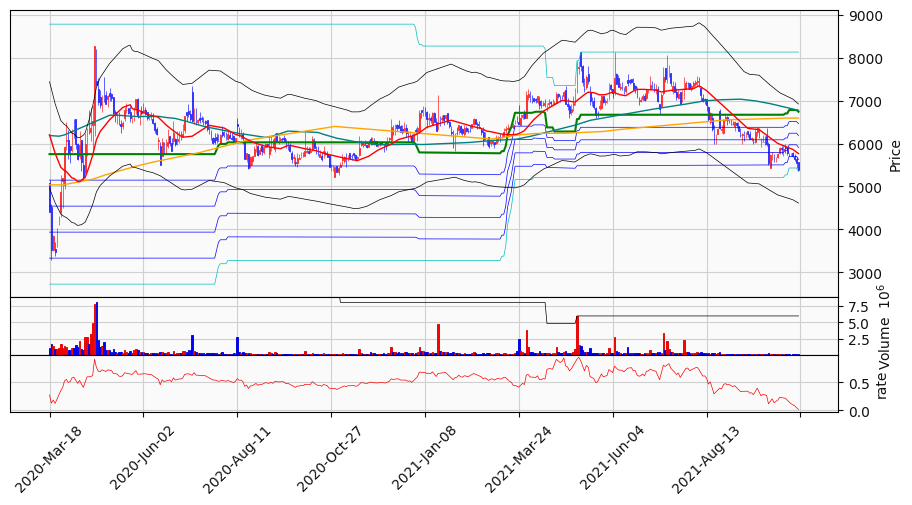

http://finance.naver.com/item/main.nhn?code=046940


,2018.12,2019.12,2020.12,2021.12(E),2020.06,2020.09,2020.12,2021.03,2021.06,2021.09(E)
주요재무정보,,,,,,,,,,
매출액,2186,2902,3163,NaN,857.00,915.00,474.00,356.00,479.00,NaN
영업이익,14,226,326,NaN,91.00,108.00,38.00,4.00,14.00,NaN
당기순이익,-14,141,168,NaN,79.00,75.00,-52.00,2.00,30.00,NaN
영업이익률,0.66,7.77,10.32,NaN,10.60,11.77,7.93,1.18,2.97,NaN
순이익률,-0.66,4.87,5.32,NaN,9.25,8.16,-11.02,0.49,6.33,NaN
ROE(지배주주),-2.39,19.50,18.28,NaN,21.43,21.17,18.28,10.79,5.43,NaN
부채비율,201.98,142.78,77.25,NaN,159.98,85.04,77.25,60.02,60.32,NaN
당좌비율,51.46,80.52,124.34,NaN,104.56,126.83,124.34,139.72,149.93,NaN
유보율,666.89,843.75,1025.34,NaN,1002.99,1067.53,1025.34,1020.91,1037.88,NaN


In [15]:
s_name = '우원개발'
drawchart(s_name,400)
stock_codes.getFinancefromNaver(s_name)

In [33]:
stock_codes.codes

,market,name,code
0,KS,DRB동일,4840
1,KS,DSR,155660
2,KS,GS글로벌,1250
3,KS,HDC현대산업개발,294870
4,KS,KEC,92220
...,...,...,...
2319,KQ,한라IMS,92460
2320,KQ,한스바이오메드,42520
2321,KQ,현대사료,16790
2322,KQ,홈센타홀딩스,60560


In [44]:
stock_codes.codes2.market.value_counts()

KOSPI     5299
KOSDAQ    1531
KONEX      134
Name: market, dtype: int64